# **Модель прогнозирования стоимости автомобилей**


----------------------------

In [3]:
import os
import re
import phik
import time
import random
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import combinations

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

random.seed(42)
np.random.seed(42)
warnings.filterwarnings("ignore") 
%matplotlib inline

----------------------

# **Часть 1 | EDA**

### 1.1. Выгрузка данных

In [4]:
df_train_raw = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_train.csv')
df_test_raw = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_test.csv')

### 1.2. Удаление дубликатов

In [5]:
## Удаление полных дубликатов
training_cols = df_train_raw.drop(columns=['selling_price']).columns
df_train_raw = df_train_raw.drop_duplicates(subset=training_cols, keep='first').reset_index().drop(columns=['index'])
df_test_raw = df_test_raw.drop_duplicates(subset=training_cols, keep='first').reset_index().drop(columns=['index'])

### 1.3. Преобразование числовых признаков

In [6]:
def parse_torque_rpm(value):
    if pd.isna(value):
        return pd.Series([np.nan, np.nan])
    
    text = str(value).lower().replace(" ", "")
    text = text.replace(",", "")

    torque_num = re.search(r'([\d\.]+)', text)
    torque_val = float(torque_num.group(1)) if torque_num else np.nan

    torque_unit = "kgm" if "kgm" in text else "nm"
    if torque_unit == "kgm":
        torque_val = torque_val * 9.80665

    rpm_match = re.search(r'(\d+)(?:-(\d+))?rpm', text)
    
    if rpm_match:
        rpm_low = int(rpm_match.group(1))
        rpm_high = int(rpm_match.group(2)) if rpm_match.lastindex == 2 else rpm_low
    else:
        rpm_match = re.search(r'(\d+)(?=\()', text)
        if rpm_match:
            rpm_low = rpm_high = int(rpm_match.group(1))
        else:
            rpm_low = rpm_high = np.nan

    return pd.Series([torque_val, rpm_high])

In [7]:
## Парсинг фичей mileage, engine, max_power, torque, являющихся сроками с разными единицами измерения
df_train = (
    df_train_raw
    .assign(
        mileage=lambda df: df['mileage'].apply(lambda x: str(x).split()[0] if len(str(x).split()) > 1 else np.nan),
        engine=lambda df: df['engine'].apply(lambda x: str(x).split()[0] if len(str(x).split()) > 1 else np.nan),
        max_power=lambda df: df['max_power'].apply(lambda x: str(x).split()[0] if len(str(x).split()) > 1 else np.nan),
        max_torque_rpm=lambda df: df['torque'].apply(parse_torque_rpm).rename(columns={1: 'max_torque_rpm'})['max_torque_rpm'],
        torque=lambda df: df['torque'].apply(parse_torque_rpm).rename(columns={0: 'torque'})['torque'],
    )
    .replace('nan', np.nan)
    .assign(mileage=lambda df: df['mileage'].astype('float'), engine=lambda df: df['engine'].astype('float'), max_power=lambda df: df['max_power'].astype('float'))
    .copy()
)

df_test = (
    df_test_raw
    .assign(
        mileage=lambda df: df['mileage'].apply(lambda x: str(x).split()[0] if len(str(x).split()) > 1 else np.nan),
        engine=lambda df: df['engine'].apply(lambda x: str(x).split()[0] if len(str(x).split()) > 1 else np.nan),
        max_power=lambda df: df['max_power'].apply(lambda x: str(x).split()[0] if len(str(x).split()) > 1 else np.nan),
        max_torque_rpm=lambda df: df['torque'].apply(parse_torque_rpm).rename(columns={1: 'max_torque_rpm'})['max_torque_rpm'],
        torque=lambda df: df['torque'].apply(parse_torque_rpm).rename(columns={0: 'torque'})['torque'],
    )
    .replace('nan', np.nan)
    .assign(mileage=lambda df: df['mileage'].astype('float'), engine=lambda df: df['engine'].astype('float'), max_power=lambda df: df['max_power'].astype('float'))
    .copy()
)

### 1.4. Обработка пропусков






In [8]:
#№ Пропуски заполняются медианами обучающей выброки на обучающей и тестовой выброке
median_vals = df_train.median(numeric_only=True)
df_train_prep = df_train.fillna(median_vals).copy()
df_test_prep = df_test.fillna(median_vals).copy()

### 1.5. Форматирование числовых признаков

In [9]:
df_train_prep = df_train_prep.assign(engine=lambda df: df['engine'].astype('int'), seats=lambda df: df['seats'].astype('int'))
df_test_prep = df_test_prep.assign(engine=lambda df: df['engine'].astype('int'), seats=lambda df: df['seats'].astype('int'))

### 1.6. Визуализация диаграмм рассеяния

In [10]:
numeric_cols = [
    'year', 'selling_price', 'km_driven', 
    'mileage', 'engine', 'max_power',
    'torque', 'seats', 'max_torque_rpm'
]

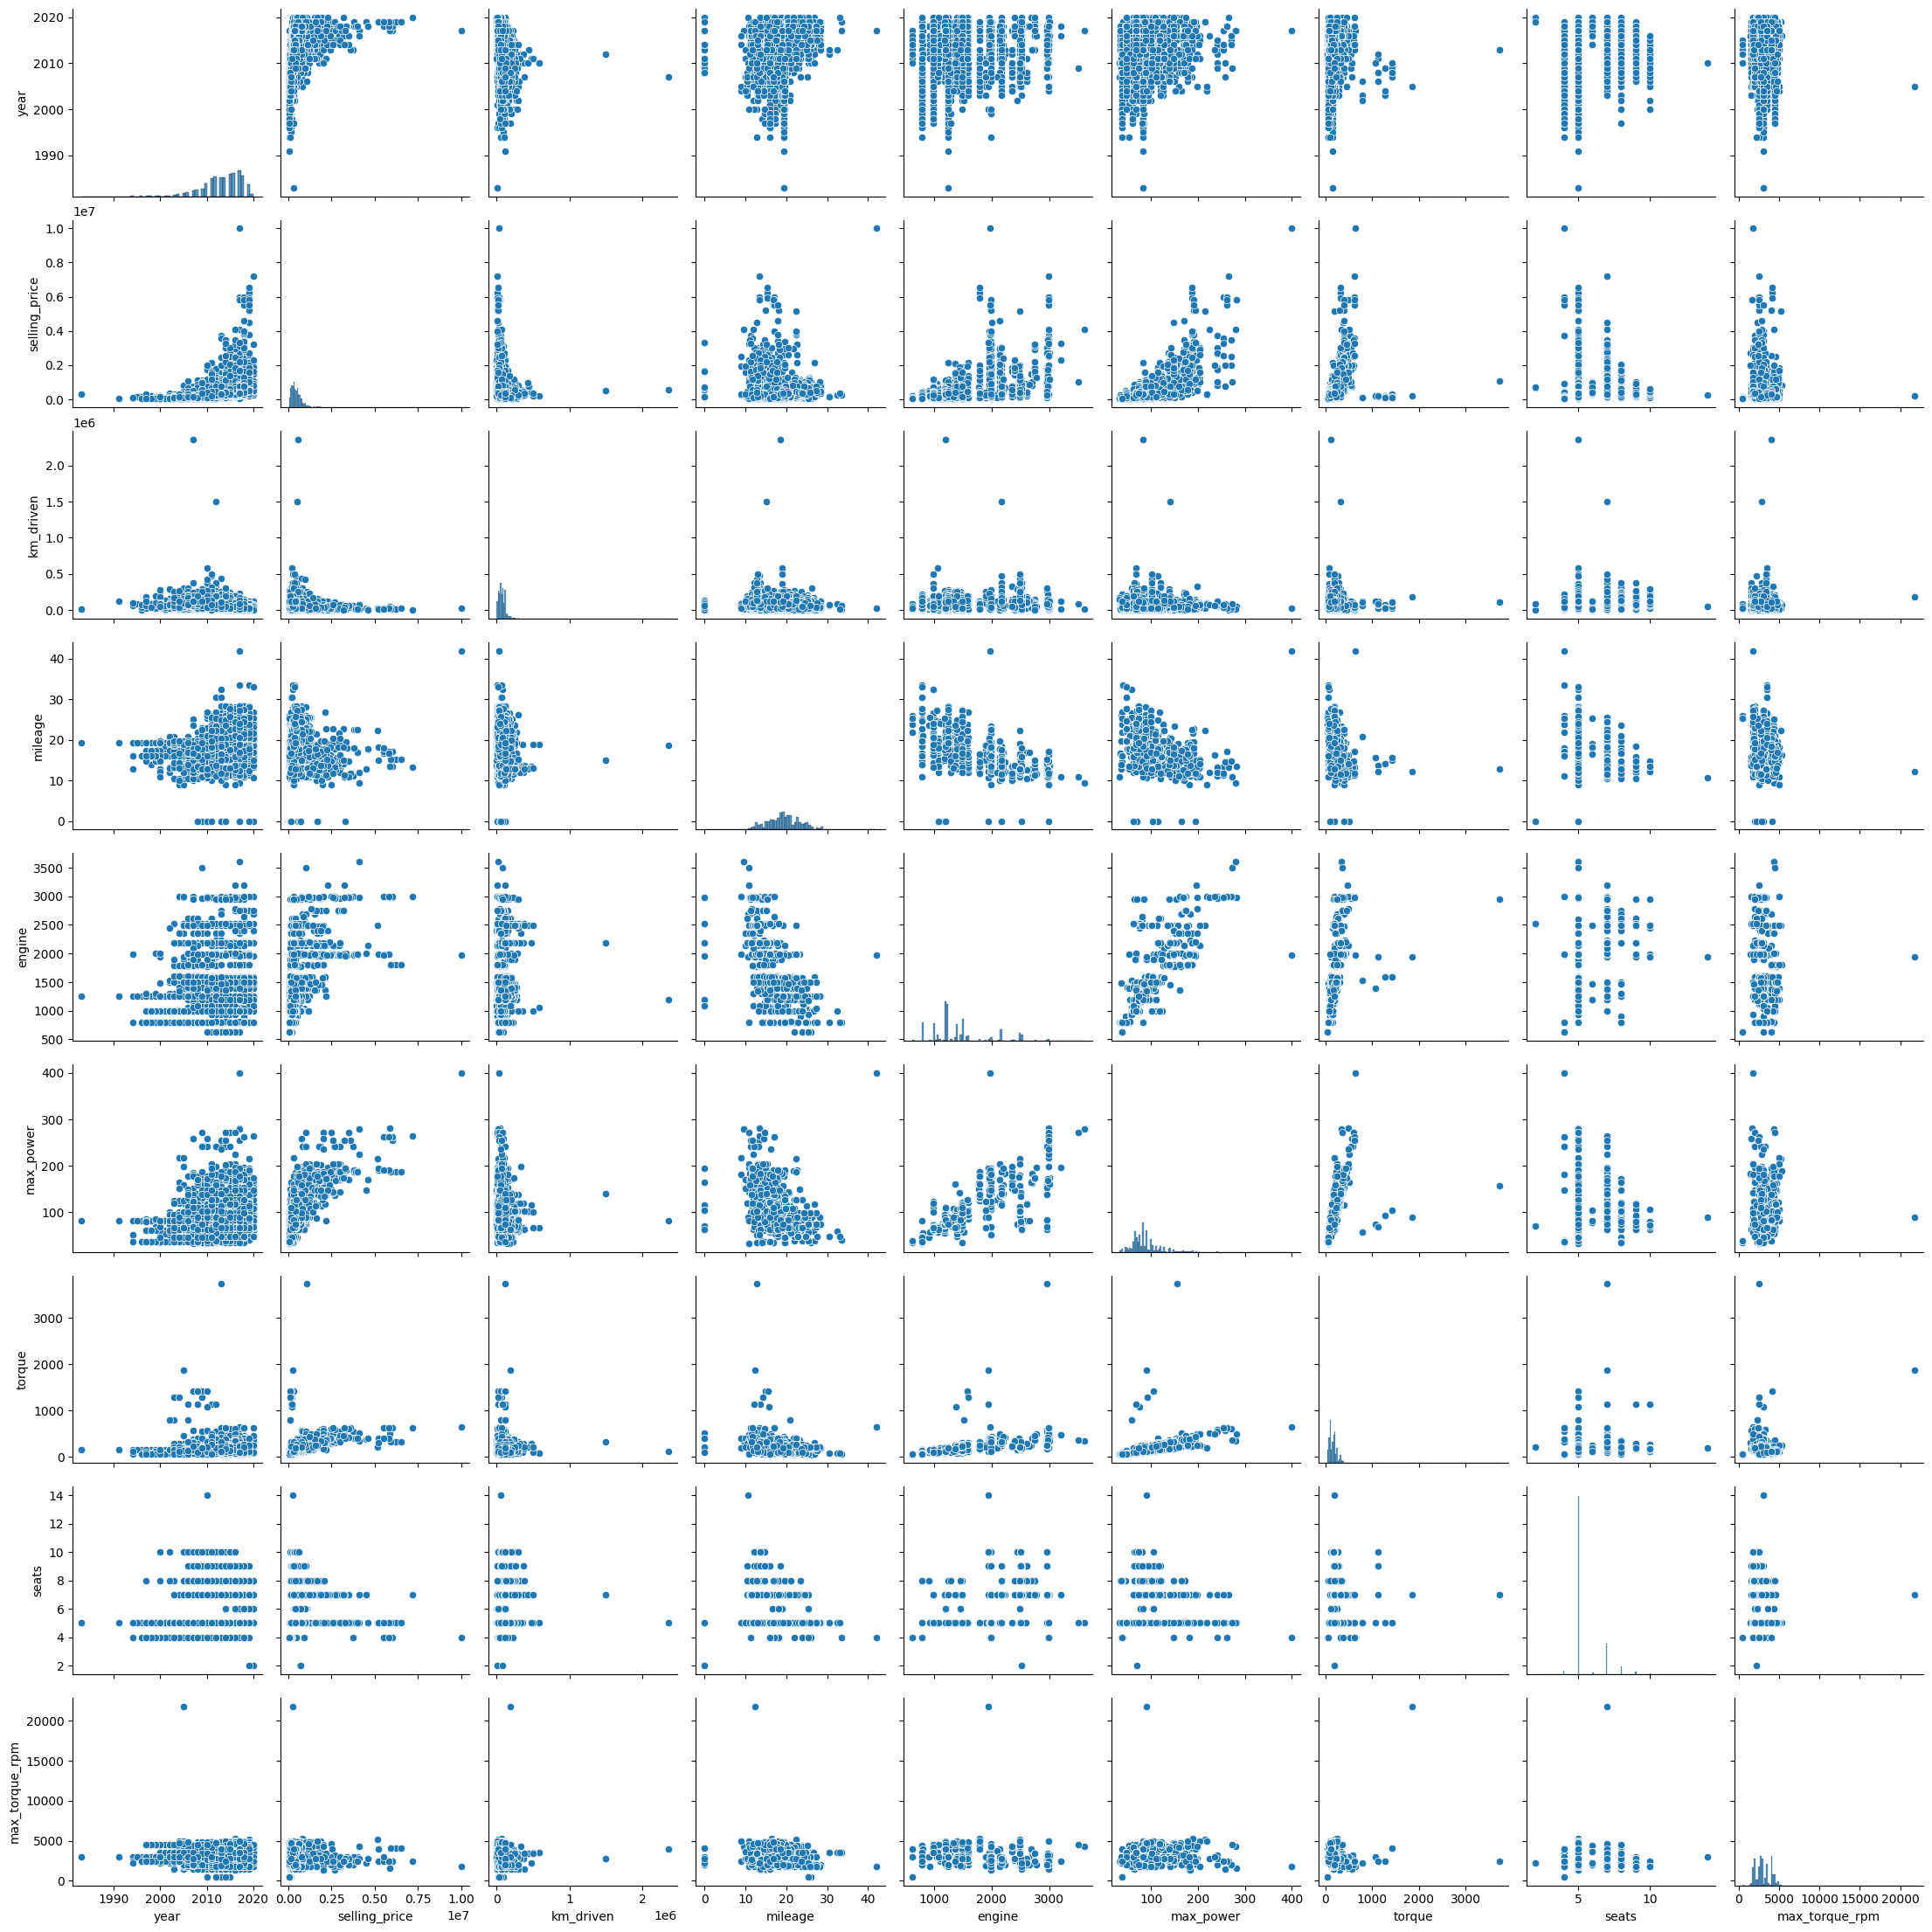

In [11]:
sns.pairplot(df_train_prep[numeric_cols])
plt.show()

### 1.6. Тепловая карта корреляции Пирсона 

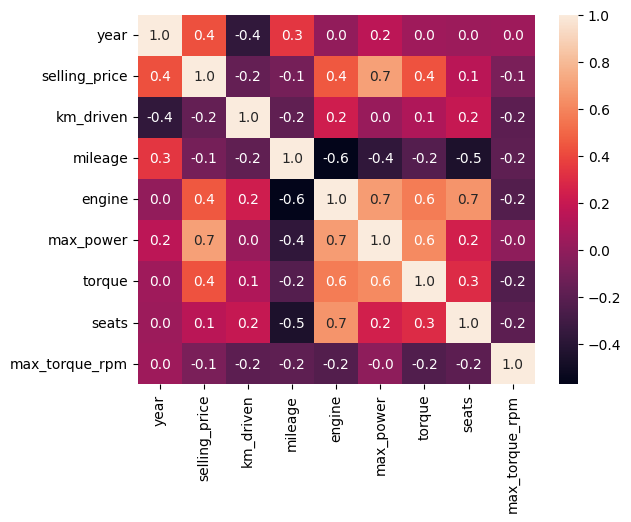

In [12]:
corr_table = df_train_prep.corr(numeric_only=True)
sns.heatmap(corr_table, annot=True, fmt=".1f")
plt.show()

### 1.6. Реализация Kendall Tau через numpy

In [13]:
## Реализация корреляции Kendall Tau-B
def kendall_tau_b(x, y):
    n = len(x)
    i, j = np.meshgrid(np.arange(n), np.arange(n))
    mask = i < j
    i = i[mask]
    j = j[mask]
    dx = x[i] - x[j]
    dy = y[i] - y[j]
    product = dx * dy

    concordant = np.sum(product > 0)
    discordant = np.sum(product < 0)
    ties_x = np.sum((dx == 0) & (dy != 0))
    ties_y = np.sum((dx != 0) & (dy == 0))
    ties_xy = np.sum((dx == 0) & (dy == 0))

    numerator = concordant - discordant
    total_pairs = n * (n - 1) // 2
    tx = ties_x + ties_xy
    ty = ties_y + ties_xy
    denom1 = total_pairs - tx
    denom2 = total_pairs - ty

    if denom1 == 0 or denom2 == 0:
        return 0.0
    return numerator / np.sqrt(np.int64(denom1) * np.int64(denom2))
    

In [14]:
manual_kendall_tau = kendall_tau_b(df_train_prep['engine'].values, df_train_prep['max_power'].values)

In [15]:
## Сравнение с библиотечной реализацией
pandas_kendall_tau = df_train_prep.corr(numeric_only=True, method='kendall').loc['engine', 'max_power']
manual_kendall_tau == pandas_kendall_tau

np.True_

### 1.6. Тепловая карта корреляции Phik

interval columns not set, guessing: ['year', 'selling_price', 'km_driven', 'mileage', 'engine', 'max_power', 'torque', 'seats', 'max_torque_rpm']


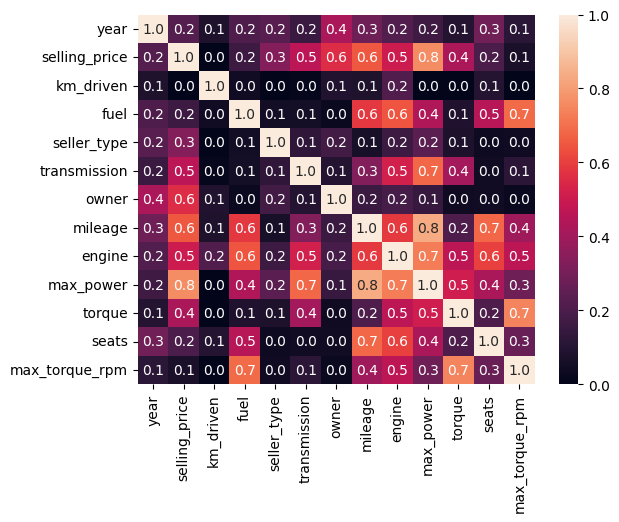

In [16]:
phik_corr = df_train_prep.drop(columns=['name']).phik_matrix()
sns.heatmap(phik_corr, annot=True, fmt=".1f")
plt.show()

### 1.7. VIF

In [17]:
def compute_vif(df):
    df_num = df.select_dtypes(include=[np.number]).dropna()
    vif_values = []

    for i in range(df_num.shape[1]):
        vif_values.append(variance_inflation_factor(df_num.values, i))

    return pd.DataFrame({
        "feature": df_num.columns,
        "VIF": vif_values
    }).set_index('feature')

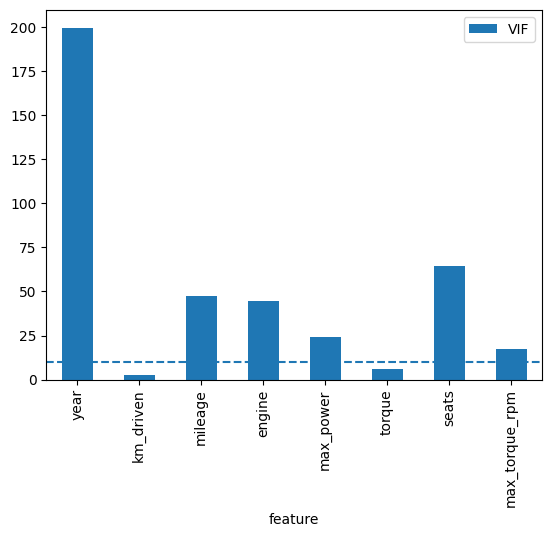

In [18]:
vif_df = compute_vif(df_train_prep.drop(columns=['selling_price']))
vif_df.plot(kind='bar')
plt.axhline(y=10, linestyle='--')
plt.show()

### 1.8. Boxplots

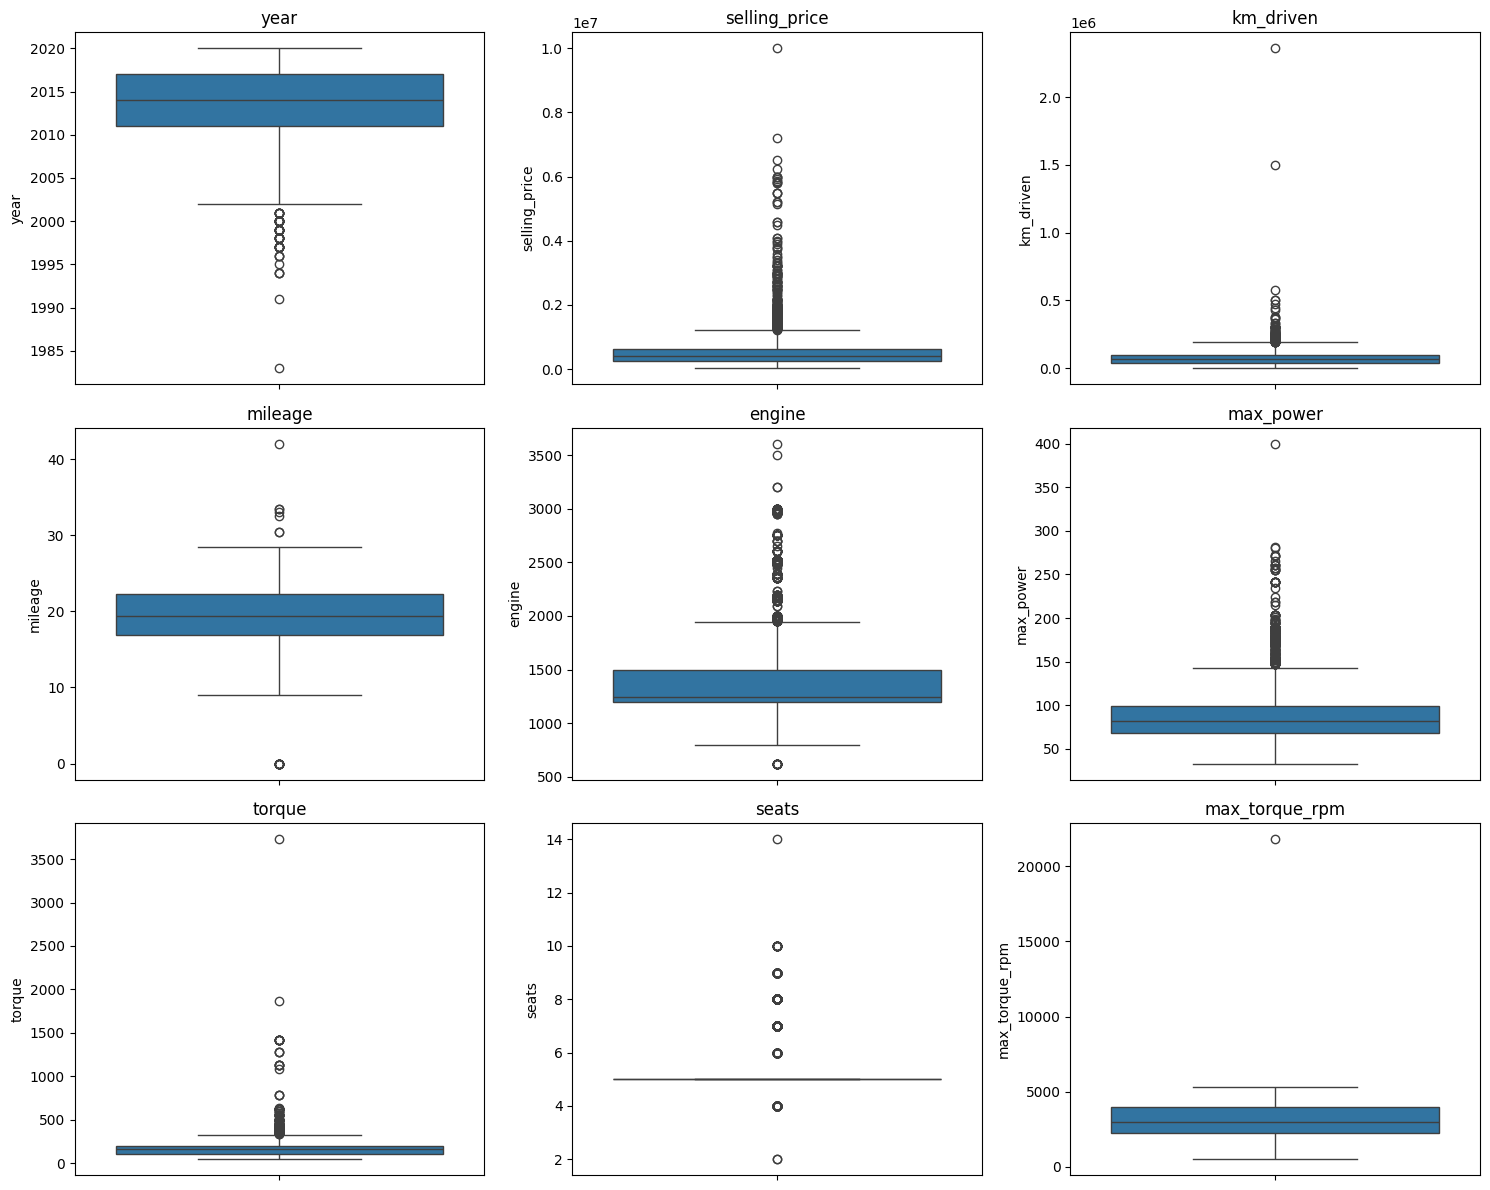

In [19]:
num_cols = df_train_prep.select_dtypes(include='number').columns
n = len(num_cols)
n_cols = 3
n_rows = (n + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(y=df_train_prep[col], ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

-----------------

# **Часть 2 | Модель только на вещественных признаках**

In [20]:
def business_metrics(y_true, y_pred):
    return np.mean(np.abs(y_pred/y_true - 1) <= 0.1)

def your_business_metrics(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    alpha = 0.1
    beta = 0.3
    n = len(y_true)
    score = np.zeros(n)

    for i in range(n):
        if y_true[i] == 0:
            rel_error = 0
        else:
            rel_error = abs(y_pred[i] - y_true[i]) / y_true[i]

        if y_pred[i] >= y_true[i]:
            score[i] = max(0.0, 1 - alpha * rel_error)
        else:
            score[i] = max(0.0, 1 - beta * rel_error)

    return score.mean() + np.mean(np.abs(y_pred / y_true - 1) <= 0.1)

### 2.1. Фильтрация датафрейма и train-test split

In [21]:
df_full = pd.concat([df_train_prep, df_test_prep])
cat_cols = ['fuel', 'seller_type', 'transmission', 'owner', 'name']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    df_full.drop(columns=['selling_price'] + cat_cols), df_full['selling_price'], test_size=0.2, random_state=1337)

### 2.2. Обучение линейной модели через МНК

In [23]:
kylie_jenner = LinearRegression()
kylie_jenner.fit(X_train, y_train)
y_preds_train = kylie_jenner.predict(X_train)
y_preds_test = kylie_jenner.predict(X_test)

In [24]:
print('MSE на трейне', MSE(y_train, y_preds_train))
print('MSE на тесте', MSE(y_test, y_preds_test))

print('R^2 на трейне', r2_score(y_train, y_preds_train))
print('R^2 на тесте', r2_score(y_test, y_preds_test))

print('Бизнес метрика на трейне', business_metrics(y_train, y_preds_train))
print('Бизнес-метрика на тесте', business_metrics(y_test, y_preds_test))

print('Кастомная бизнес метрика на трейне', your_business_metrics(y_train, y_preds_train))
print('Кастомная бизнес на тесте', your_business_metrics(y_test, y_preds_test))

kylie_jenner_bmetr1_test  = business_metrics(y_test, y_preds_test)
kylie_jenner_bmetr2_test  = your_business_metrics(y_test, y_preds_test)

MSE на трейне 122763456245.47797
MSE на тесте 93373458176.48387
R^2 на трейне 0.5998813714361018
R^2 на тесте 0.6345282425102755
Бизнес метрика на трейне 0.2147341211225997
Бизнес-метрика на тесте 0.24575645756457565
Кастомная бизнес метрика на трейне 1.107469640155323
Кастомная бизнес на тесте 1.146577468606775


### 2.2. Реализация $R^2$ через numpy

In [25]:
def calc_r2(Xtrain, ytrain, Xtest, ytest, *, sample):
    Xtrain, Xtest = add_constant(Xtrain), add_constant(Xtest) 
    beta_hat = np.linalg.inv(Xtrain.values.T @ Xtrain.values) @ Xtrain.values.T @ ytrain.values
    if sample == 'test':
        y_hat = Xtest @ beta_hat
        resid = ytest - y_hat
        return 1 - (resid.T @ resid) / ((ytest - ytest.mean()).T @ (ytest - ytest.mean()))
    y_hat = Xtrain @ beta_hat
    resid = ytrain - y_hat
    return 1 - (resid.T @ resid) / ((ytrain - ytrain.mean()).T @ (ytrain - ytrain.mean()))

In [26]:
calc_r2(X_train, y_train, X_test, y_test, sample='test')

np.float64(0.6345282425130545)

### 2.3. Реализация $R^2_{adj}$ через numpy

In [27]:
def calc_r2_adj(Xtrain, ytrain, Xtest, ytest, *, sample):
    Xtrain, Xtest = add_constant(Xtrain), add_constant(Xtest)
    beta_hat = np.linalg.inv(Xtrain.values.T @ Xtrain.values) @ Xtrain.values.T @ ytrain.values
    if sample == 'test':
        X_calc, y_calc = Xtest, ytest
    else:
        X_calc, y_calc = Xtrain, ytrain
    y_hat = X_calc @ beta_hat
    resid = y_calc - y_hat
    n = len(y_hat)
    p = X_calc.shape[1] - 1
    r2_value = 1 - (resid.T @ resid) / ((y_calc - y_calc.mean()).T @ (y_calc - y_calc.mean()))
    return 1 - (1 - r2_value) * (n - 1)/(n - p - 1)

In [28]:
calc_r2_adj(X_train, y_train, X_test, y_test, sample='test')

np.float64(0.6323560478177384)

### 2.4. Стандартизация признаков

In [29]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 2.5. Обучение линейной регресии с МНК на стандартизованных данных

In [30]:
kendall_jenner = LinearRegression()
kendall_jenner.fit(X_train_scaled, y_train)
y_preds_train = kendall_jenner.predict(X_train_scaled)
y_preds_test = kendall_jenner.predict(X_test_scaled)

In [31]:
print('MSE на трейне', MSE(y_train, y_preds_train))
print('MSE на тесте', MSE(y_test, y_preds_test))

print('R^2 на трейне', r2_score(y_train, y_preds_train))
print('R^2 на тесте', r2_score(y_test, y_preds_test))

print('Бизнес метрика на трейне', business_metrics(y_train, y_preds_train))
print('Бизнес-метрика на тесте', business_metrics(y_test, y_preds_test))

print('Кастомная бизнес метрика на трейне', your_business_metrics(y_train, y_preds_train))
print('Кастомная бизнес на тесте', your_business_metrics(y_test, y_preds_test))

kendall_jenner_bmetr1_test  = business_metrics(y_test, y_preds_test)
kendall_jenner_bmetr2_test  = your_business_metrics(y_test, y_preds_test)

MSE на трейне 122763456245.47812
MSE на тесте 93373458176.48402
R^2 на трейне 0.5998813714361012
R^2 на тесте 0.6345282425102748
Бизнес метрика на трейне 0.2147341211225997
Бизнес-метрика на тесте 0.24575645756457565
Кастомная бизнес метрика на трейне 1.1074696401553235
Кастомная бизнес на тесте 1.146577468606775


In [32]:
df_betas = pd.DataFrame({
    'variable': ['const'] + X_train.columns.tolist(),
    'beta': [kendall_jenner.intercept_] + kendall_jenner.coef_.tolist(),
}).set_index('variable')
df_betas.abs().sort_values(by='beta', ascending=False).head(2)

,beta
variable,
const,525869.048744
max_power,352970.987312


### 2.6. Обучение линейной регресии с МНК и l1 регуляризацией на стандартизованных данных

In [33]:
anok_yai = Lasso(random_state=1337)
anok_yai.fit(X_train_scaled, y_train)
y_preds_train = anok_yai.predict(X_train_scaled)
y_preds_test = anok_yai.predict(X_test_scaled)

In [34]:
print('MSE на трейне', MSE(y_train, y_preds_train))
print('MSE на тесте', MSE(y_test, y_preds_test))

print('R^2 на трейне', r2_score(y_train, y_preds_train))
print('R^2 на тесте', r2_score(y_test, y_preds_test))

print('Бизнес метрика на трейне', business_metrics(y_train, y_preds_train))
print('Бизнес-метрика на тесте', business_metrics(y_test, y_preds_test))

print('Кастомная бизнес метрика на трейне', your_business_metrics(y_train, y_preds_train))
print('Кастомная бизнес на тесте', your_business_metrics(y_test, y_preds_test))

anok_yai_bmetr1_test  = business_metrics(y_test, y_preds_test)
anok_yai_bmetr2_test  = your_business_metrics(y_test, y_preds_test)

MSE на трейне 122763456266.88275
MSE на тесте 93373093223.51598
R^2 на трейне 0.5998813713663378
R^2 на тесте 0.6345296709676249
Бизнес метрика на трейне 0.2147341211225997
Бизнес-метрика на тесте 0.24575645756457565
Кастомная бизнес метрика на трейне 1.1074703849410183
Кастомная бизнес на тесте 1.1465779554074964


In [35]:
df_betas = pd.DataFrame({
    'variable': ['const'] + X_train.columns.tolist(),
    'beta': [anok_yai.intercept_] + anok_yai.coef_.tolist(),
}).set_index('variable')
df_betas

,beta
variable,
const,525869.048744
year,166465.806802
km_driven,-52531.752282
mileage,-15477.722707
engine,17193.450641
max_power,352969.830548
torque,-2726.578237
seats,-37454.478493
max_torque_rpm,-68244.533884


### 2.6. Обучение линейной регресии с МНК и l1 регуляризацией на стандартизованных данных с перебором гиперпараметра по сетке

In [36]:
alphas = np.logspace(-1, 10, 50)
naomi_campbell = Lasso(random_state=1337)
start = time.time()
grd_srch = GridSearchCV(naomi_campbell, param_grid={'alpha': alphas}, cv=10, scoring='r2')
grd_srch.fit(X_train_scaled, y_train)
end = time.time()
print('На обучение ушло секунд:', end - start)
print('Оптимальный параметр регуляризации:', grd_srch.best_params_['alpha'])


На обучение ушло секунд: 1.03074312210083
Оптимальный параметр регуляризации: 8685.11373751352


In [37]:
naomi_campbell = Lasso(random_state=1337, alpha=grd_srch.best_params_['alpha']).fit(X_train_scaled, y_train)
y_preds_train = naomi_campbell.predict(X_train_scaled)
y_preds_test = naomi_campbell.predict(X_test_scaled)

In [38]:
print('MSE на трейне', MSE(y_train, y_preds_train))
print('MSE на тесте', MSE(y_test, y_preds_test))

print('R^2 на трейне', r2_score(y_train, y_preds_train))
print('R^2 на тесте', r2_score(y_test, y_preds_test))

print('Бизнес метрика на трейне', business_metrics(y_train, y_preds_train))
print('Бизнес-метрика на тесте', business_metrics(y_test, y_preds_test))

print('Кастомная бизнес метрика на трейне', your_business_metrics(y_train, y_preds_train))
print('Кастомная бизнес на тесте', your_business_metrics(y_test, y_preds_test))

naomi_campbell_bmetr1_test  = business_metrics(y_test, y_preds_test)
naomi_campbell_bmetr2_test  = your_business_metrics(y_test, y_preds_test)

MSE на трейне 123441862535.00018
MSE на тесте 92456194196.82082
R^2 на трейне 0.5976702656031903
R^2 на тесте 0.6381184927299456
Бизнес метрика на трейне 0.21916543574593797
Бизнес-метрика на тесте 0.23911439114391145
Кастомная бизнес метрика на трейне 1.11747805253419
Кастомная бизнес на тесте 1.144932583522677


In [39]:
df_betas = pd.DataFrame({
    'variable': ['const'] + X_train.columns.tolist(),
    'beta': [naomi_campbell.intercept_] + naomi_campbell.coef_.tolist(),
}).set_index('variable')
df_betas

,beta
variable,
const,525869.048744
year,152779.778964
km_driven,-44317.652333
mileage,-0.000000
engine,0.000000
max_power,355486.245131
torque,0.000000
seats,-9736.644608
max_torque_rpm,-51502.332632


### 2.7. Обучение линейной регресии с МНК и l1l2 регуляризацией на стандартизованных данных с перебором гиперпараметров по сетке

In [40]:
alphas = np.logspace(-1, 10, 50)
l1_ratios = np.linspace(0, 1, 20)

adriana_lima = ElasticNet(random_state=1337)
start = time.time()
grd_srch = GridSearchCV(adriana_lima, param_grid={'alpha': alphas, 'l1_ratio': l1_ratios}, cv=10, scoring='r2')
grd_srch.fit(X_train_scaled, y_train)
end = time.time()
print('На обучение ушло секунд:', end - start)
print('Оптимальный параметр регуляризации:', grd_srch.best_params_['alpha'])

На обучение ушло секунд: 32.280431270599365
Оптимальный параметр регуляризации: 8685.11373751352


In [41]:
print('Оптимальное соотношение l1 и l2 регуляризации', grd_srch.best_params_['l1_ratio'])

Оптимальное соотношение l1 и l2 регуляризации 1.0


In [42]:
adriana_lima = ElasticNet(random_state=1337, alpha=8685.11373751352, l1_ratio=1.0).fit(X_train_scaled, y_train)
y_preds_train = adriana_lima.predict(X_train_scaled)
y_preds_test = adriana_lima.predict(X_test_scaled)

In [43]:
print('MSE на трейне', MSE(y_train, y_preds_train))
print('MSE на тесте', MSE(y_test, y_preds_test))

print('R^2 на трейне', r2_score(y_train, y_preds_train))
print('R^2 на тесте', r2_score(y_test, y_preds_test))

print('Бизнес метрика на трейне', business_metrics(y_train, y_preds_train))
print('Бизнес-метрика на тесте', business_metrics(y_test, y_preds_test))

print('Кастомная бизнес метрика на трейне', your_business_metrics(y_train, y_preds_train))
print('Кастомная бизнес на тесте', your_business_metrics(y_test, y_preds_test))

adriana_lima_bmetr1_test  = business_metrics(y_test, y_preds_test)
adriana_lima_bmetr2_test  = your_business_metrics(y_test, y_preds_test)

MSE на трейне 123441862535.00018
MSE на тесте 92456194196.82082
R^2 на трейне 0.5976702656031903
R^2 на тесте 0.6381184927299456
Бизнес метрика на трейне 0.21916543574593797
Бизнес-метрика на тесте 0.23911439114391145
Кастомная бизнес метрика на трейне 1.11747805253419
Кастомная бизнес на тесте 1.144932583522677


### 2.7. Обучение линейной регресии с МНК и псевдо-l0 регуляризацией (через l1) на стандартизованных данных с перебором гиперпараметров циклом



In [44]:
def l0_linear_regression(X, y, lam):
    n_samples, n_features = X.shape
    best_cost = np.inf
    best_w = np.zeros(n_features)
    best_subset = []

    for k in range(1, n_features + 1):
        for subset in combinations(range(n_features), k):
            subset = list(subset)
            Xs = X[:, subset].copy()
            model = LinearRegression().fit(Xs, y)
            w_sub = model.coef_
            pred = model.predict(Xs)
            cost = np.sum((y - pred)**2) + lam * k
            if cost < best_cost:
                best_cost = cost
                best_subset = subset
    return best_subset, best_cost

In [45]:
best_cost_reg = np.inf
best_reg = None
best_features = []
for reg in tqdm(np.logspace(-1, 5, 50)):
    selected, cost = l0_linear_regression(X_train_scaled, y_train, lam=reg)
    if cost < best_cost_reg:
        best_reg = reg
        best_features = selected

100%|██████████| 50/50 [00:11<00:00,  4.24it/s]


In [46]:
print('Незануленные признаки:', best_features, 'Коэффициент регуляризации', best_reg)

Незануленные признаки: [0, 1, 2, 3, 4, 5, 6, 7] Коэффициент регуляризации 100000.0


In [47]:
barbara_palvin = Lasso(random_state=1337, alpha=best_reg).fit(X_train_scaled[:, best_features], y_train)
y_preds_train = barbara_palvin.predict(X_train_scaled[:, best_features])
y_preds_test = barbara_palvin.predict(X_test_scaled[:, best_features])

In [48]:
print('MSE на трейне', MSE(y_train, y_preds_train))
print('MSE на тесте', MSE(y_test, y_preds_test))

print('R^2 на трейне', r2_score(y_train, y_preds_train))
print('R^2 на тесте', r2_score(y_test, y_preds_test))

print('Бизнес метрика на трейне', business_metrics(y_train, y_preds_train))
print('Бизнес-метрика на тесте', business_metrics(y_test, y_preds_test))

print('Кастомная бизнес метрика на трейне', your_business_metrics(y_train, y_preds_train))
print('Кастомная бизнес на тесте', your_business_metrics(y_test, y_preds_test))

barbara_palvin_bmetr1_test  = business_metrics(y_test, y_preds_test)
barbara_palvin_bmetr2_test  = your_business_metrics(y_test, y_preds_test)

MSE на трейне 145740104313.7866
MSE на тесте 110807268236.26102
R^2 на трейне 0.5249943880026613
R^2 на тесте 0.5662908083751277
Бизнес метрика на трейне 0.19571639586410636
Бизнес-метрика на тесте 0.2088560885608856
Кастомная бизнес метрика на трейне 1.117580443731081
Кастомная бизнес на тесте 1.1365359337320071


# **Часть 3 | Модель на количественных и категориальных фичах**



### 3.1. Энкодинг категориальных фичей

In [49]:
## Выделение марки автомобиля как категориальную переменную. Была идея также взять модель, однако там 207 категорий, что не очень хорошо для модели
df_full_cat = (
    df_full
    .assign(
        name=lambda df: df['name'].apply(lambda x: str(x).split()[0]).str.lower(),
    )
    .copy()
)
ohe = OneHotEncoder(sparse_output=False, drop='first')
cat_cols = ['seats', 'fuel', 'seller_type', 'transmission', 'owner', 'name']
transformed = ohe.fit_transform(df_full_cat[cat_cols].astype('category'))
new_cols = [f"{col_name}_{cat}" for col_name, col_cats in zip(cat_cols, ohe.categories_) for cat in col_cats[1:]]
df_ohe = pd.DataFrame(transformed, index=df_full_cat.index, columns=new_cols)
df_full_cat = pd.concat([df_full_cat.drop(columns=cat_cols), df_ohe], axis=1)

### 3.2. Train-test сплит и стандартизация фичей

In [50]:
X_train, X_test, y_train, y_test = train_test_split(
    df_full_cat.drop(columns=['selling_price']), df_full_cat['selling_price'], test_size=0.2, random_state=1337)

In [51]:
scaler = StandardScaler()
X_train = pd.concat([pd.DataFrame(scaler.fit_transform(X_train.drop(columns=new_cols)), columns=X_train.drop(columns=new_cols).columns, index=X_train.index), X_train[new_cols]], axis=1)
X_test = pd.concat([pd.DataFrame(scaler.transform(X_test.drop(columns=new_cols)), columns=X_test.drop(columns=new_cols).columns, index=X_test.index), X_test[new_cols]], axis=1)

### 3.3. Обучение линейной регресии с МНК и l2 регуляризацией на стандартизованных данных с перебором гиперпараметра по сетке

In [52]:
alphas = np.logspace(-1, 10, 50)
hailey_baldwin = Ridge(random_state=1337)
start = time.time()
grd_srch = GridSearchCV(hailey_baldwin, param_grid={'alpha': alphas}, cv=10, scoring='r2')
grd_srch.fit(X_train, y_train)
end = time.time()
print('На обучение ушло секунд:', end - start)
print('Оптимальный параметр регуляризации:', grd_srch.best_params_['alpha'])

На обучение ушло секунд: 3.5709550380706787
Оптимальный параметр регуляризации: 0.28117686979742307


In [53]:
hailey_baldwin = Ridge(random_state=1337, alpha=grd_srch.best_params_['alpha']).fit(X_train, y_train)
y_preds_train = hailey_baldwin.predict(X_train)
y_preds_test = hailey_baldwin.predict(X_test)

In [54]:
print('MSE на трейне', MSE(y_train, y_preds_train))
print('MSE на тесте', MSE(y_test, y_preds_test))

print('R^2 на трейне', r2_score(y_train, y_preds_train))
print('R^2 на тесте', r2_score(y_test, y_preds_test))

print('Бизнес метрика на трейне', business_metrics(y_train, y_preds_train))
print('Бизнес-метрика на тесте', business_metrics(y_test, y_preds_test))

print('Кастомная бизнес метрика на трейне', your_business_metrics(y_train, y_preds_train))
print('Кастомная бизнес на тесте', your_business_metrics(y_test, y_preds_test))

hailey_baldwin_bmetr1_test  = business_metrics(y_test, y_preds_test)
hailey_baldwin_bmetr2_test  = your_business_metrics(y_test, y_preds_test)

MSE на трейне 69136885116.23209
MSE на тесте 58910228336.93543
R^2 на трейне 0.7746645744432962
R^2 на тесте 0.769420292394792
Бизнес метрика на трейне 0.279357459379616
Бизнес-метрика на тесте 0.2767527675276753
Кастомная бизнес метрика на трейне 1.1939063980365323
Кастомная бизнес на тесте 1.1986169763463326


----------------------

# **Часть 4 | Feature Engineering**

#### 4.0. Повторный парсинг количественных переменных

In [55]:
df_train_upd = (
    df_train_raw
    .assign(
        mileage=lambda df: df['mileage'].apply(lambda x: str(x).split()[0] if len(str(x).split()) > 1 else np.nan),
        engine=lambda df: df['engine'].apply(lambda x: str(x).split()[0] if len(str(x).split()) > 1 else np.nan),
        max_power=lambda df: df['max_power'].apply(lambda x: str(x).split()[0] if len(str(x).split()) > 1 else np.nan),
        max_torque_rpm=lambda df: df['torque'].apply(parse_torque_rpm).rename(columns={1: 'max_torque_rpm'})['max_torque_rpm'],
        torque=lambda df: df['torque'].apply(parse_torque_rpm).rename(columns={0: 'torque'})['torque'],
    )
    .replace('nan', np.nan)
    .assign(mileage=lambda df: df['mileage'].astype('float'), engine=lambda df: df['engine'].astype('float'), max_power=lambda df: df['max_power'].astype('float'))
    .copy()
)

df_test_upd = (
    df_test_raw
    .assign(
        mileage=lambda df: df['mileage'].apply(lambda x: str(x).split()[0] if len(str(x).split()) > 1 else np.nan),
        engine=lambda df: df['engine'].apply(lambda x: str(x).split()[0] if len(str(x).split()) > 1 else np.nan),
        max_power=lambda df: df['max_power'].apply(lambda x: str(x).split()[0] if len(str(x).split()) > 1 else np.nan),
        max_torque_rpm=lambda df: df['torque'].apply(parse_torque_rpm).rename(columns={1: 'max_torque_rpm'})['max_torque_rpm'],
        torque=lambda df: df['torque'].apply(parse_torque_rpm).rename(columns={0: 'torque'})['torque'],
    )
    .replace('nan', np.nan)
    .assign(mileage=lambda df: df['mileage'].astype('float'), engine=lambda df: df['engine'].astype('float'), max_power=lambda df: df['max_power'].astype('float'))
    .copy()
)

#### 4.1. Обработка выбросов

In [56]:
df_train_upd = (
    df_train_upd
    .assign(
        selling_price=lambda df: np.log(df['selling_price']),
        max_power=lambda df: np.log(df['max_power']),
        km_driven=lambda df: np.log(df['km_driven']),
        engine=lambda df: np.log(df['engine']),
        torque=lambda df: np.log(df['torque']),
        max_torque_rpm=lambda df: np.log(df['max_torque_rpm']),
        name=lambda df: df['name'].apply(lambda x: str(x).split()[0]).str.lower(),
    )
    .drop_duplicates()
)
df_test_upd = (
    df_test_upd
    .assign(
        selling_price=lambda df: np.log(df['selling_price']),
        max_power=lambda df: np.log(df['max_power']),
        km_driven=lambda df: np.log(df['km_driven']),
        engine=lambda df: np.log(df['engine']),
        torque=lambda df: np.log(df['torque']),
        max_torque_rpm=lambda df: np.log(df['max_torque_rpm']),
        name=lambda df: df['name'].apply(lambda x: str(x).split()[0]).str.lower(),
        
    )
    .drop_duplicates()
)

#### 4.2. Создание новых категорий

In [57]:
df_full_new = pd.concat([df_train_upd, df_test_upd], axis=0).copy()

In [58]:
df_full_new = (
      df_full_new
      .assign(
          is_first_owner=lambda x: (x['owner'] == 'First Owner').astype(int),
          is_second_owner=lambda x: (x['owner'] == 'Second Owner').astype(int),
          is_third_plus_owner=lambda x: x['owner'].isin(['Third Owner', 'Fourth & Above Owner']).astype(int),
          
          owner_count=lambda x: x['owner'].map({
              'First Owner': 1,
              'Second Owner': 2,
              'Third Owner': 3,
              'Fourth & Above Owner': 4
          })
      )
      .assign(
          good_car_rule=lambda x: (
              (x['owner'] == 'First Owner') &
              (x['seller_type'] == 'Dealer') &
              (x['km_driven'] < 50000) &
              (x['year'] > 2015)
          ).astype(int),
          problem_car_rule=lambda x: (
              x['owner'].isin(['Third Owner', 'Fourth & Above Owner']) |
              (x['km_driven'] > 150000) |
              (x['year'] < 2010)
          ).astype(int),
          excellent_condition=lambda x: (
              (x['km_driven'] < 30000) &
              (x['owner'].isin(['First Owner', 'Second Owner'])) &
              (x['year'] > 2018)
          ).astype(int),
          commercial_use=lambda x: (
              (x['km_driven'] > 100000) &
              (x['year'] > 2015) &
              (x['owner_count'] >= 2)
          ).astype(int),
          dealer_premium=lambda x: (
              (x['seller_type'] == 'Dealer') &
              (x['owner'] == 'First Owner') &
              (x['km_driven'] < 80000)
          ).astype(int),
          economic_choice=lambda x: (
              (x['mileage'] > 20) &
              (x['km_driven'] < 100000) &
              (x['year'] > 2012)
          ).astype(int),
      )
      .assign(
          is_premium_brand=lambda x: x['name'].isin([
              'bmw', 'mercedes', 'audi', 'lexus', 
              'jaguar', 'porsche', 'volvo'
          ]).astype(int),
          
          premium_maintained=lambda x: (
              x['is_premium_brand'] &
              (x['owner'] == 'First Owner') &
              (x['km_driven'] < 60000)
          ).astype(int),
      )
      .assign(
          age=lambda x: 2025 - x['year'],
          km_per_year=lambda x: x['km_driven'] / x['age'].clip(lower=1),
          usage_group=lambda x: pd.cut(
              x['km_per_year'],
              bins=[0, 10000, 20000, float('inf')],
              labels=['low_usage', 'normal_usage', 'high_usage']
          ),
          age_group=lambda x: pd.cut(
              x['age'],
              bins=[0, 3, 7, 15, float('inf')],
              labels=['new', 'young', 'middle_aged', 'old']
          )
      )
).drop(columns=['transmission', 'owner', 'name', 'year'])

In [59]:
ohe = OneHotEncoder(sparse_output=False, drop='first')
cat_cols = ['fuel', 'usage_group', 'age_group', 'seller_type']
transformed = ohe.fit_transform(df_full_new[cat_cols].astype('category'))
new_cols = [f"{col_name}_{cat}" for col_name, col_cats in zip(cat_cols, ohe.categories_) for cat in col_cats[1:]]
df_ohe = pd.DataFrame(transformed, index=df_full_new.index, columns=new_cols)
df_full_new = pd.concat([df_full_new.drop(columns=cat_cols), df_ohe], axis=1)

#### 4.4. Генерация новых признаков из существующих

In [60]:
df_full_new = (
    df_full_new
    .assign(
        max_torque_ratio=lambda df: df['max_torque_rpm'] / df['torque'],
        age_sq=lambda df: df['age'] **2, 
    )
    .assign(
        driving_intensity=lambda df: df['km_driven'] / (df['age']),
        total_fuel_cost=lambda df: df['km_driven'] * (1 / df['mileage']),
    )
    .replace(np.inf, np.nan)
)

#### 4.5. Заполнение пропусков предиктами модели МНК + l1 регуляризация

In [61]:
X_train, X_test, y_train, y_test = train_test_split(
    df_full_new.drop(columns=['selling_price']), df_full_new['selling_price'], test_size=0.2, random_state=1337
)
for target in df_full_new.columns[df_full_new.isna().any()]:
    
    y = X_train[target]
    y_test_target = X_test[target]
    
    X = X_train.drop(columns=[target])
    X_test_sub = X_test.drop(columns=[target])
    
    medians = X.median()

    notna_mask = y.notna()
    X_train_sub = X.loc[notna_mask].fillna(medians)
    y_train_sub = y.loc[notna_mask]

    model = Lasso()
    model.fit(X_train_sub, y_train_sub)

    missing_mask_train = y.isna()
    X_missing_train = X.loc[missing_mask_train].fillna(medians)
    y_pred_train = model.predict(X_missing_train)

    missing_mask_test = y_test_target.isna()
    X_missing_test = X_test_sub.loc[missing_mask_test].fillna(medians)
    y_pred_test = model.predict(X_missing_test)

    X_train.loc[missing_mask_train, target] = y_pred_train
    X_test.loc[missing_mask_test, target] = y_pred_test

#### 4.5. Lasso-регресия

In [62]:
numeric_features = [
       'age', 'km_driven', 'mileage', 'engine',
       'max_power', 'torque','seats', 'max_torque_rpm',
       'age_sq', 'driving_intensity', 'max_torque_ratio',
       'total_fuel_cost',
]

In [63]:
scaler = StandardScaler()
X_train_scaled = pd.concat([pd.DataFrame(scaler.fit_transform(X_train[numeric_features]), columns=numeric_features, index=X_train.index), X_train.drop(columns=numeric_features)], axis=1)
X_test_scaled = pd.concat([pd.DataFrame(scaler.transform(X_test[numeric_features]), columns=numeric_features, index=X_test.index), X_test.drop(columns=numeric_features)], axis=1)

In [64]:
alphas = np.logspace(-4, 10, 50)
gigi_hadid = Lasso(random_state=1337)
start = time.time()
grd_srch = GridSearchCV(gigi_hadid, param_grid={'alpha': alphas}, cv=10, scoring='r2')
grd_srch.fit(X_train_scaled, y_train)
end = time.time()
print('На обучение ушло секунд:', end - start)
print('Оптимальный параметр регуляризации:', grd_srch.best_params_['alpha'])

На обучение ушло секунд: 6.388302803039551
Оптимальный параметр регуляризации: 0.0001


In [70]:
gigi_hadid = Lasso(random_state=1337, alpha=grd_srch.best_params_['alpha']).fit(X_train_scaled, y_train)
y_preds_train = gigi_hadid.predict(X_train_scaled)
y_preds_test = gigi_hadid.predict(X_test_scaled)
y_preds_train = np.exp(y_preds_train)
y_preds_test = np.exp(y_preds_test)
y_train_exp = np.exp(y_train)
y_test_exp = np.exp(y_test)

print('MSE на трейне', MSE(y_train_exp, y_preds_train))
print('MSE на тесте', MSE(y_test_exp, y_preds_test))
print('R^2 на трейне', r2_score(y_train_exp, y_preds_train))
print('R^2 на тесте', r2_score(y_test_exp, y_preds_test))

print('Бизнес метрика на трейне', business_metrics(y_train_exp, y_preds_train))
print('Бизнес-метрика на тесте', business_metrics(y_test_exp, y_preds_test))

print('Кастомная бизнес метрика на трейне', your_business_metrics(y_train_exp, y_preds_train))
print('Кастомная бизнес на тесте', your_business_metrics(y_test_exp, y_preds_test))

gigi_hadid_bmetr1_test  = business_metrics(y_test_exp, y_preds_test)
gigi_hadid_bmetr2_test  = your_business_metrics(y_test_exp, y_preds_test)

MSE на трейне 55606938538.07453
MSE на тесте 43623467428.61879
R^2 на трейне 0.8259177758303
R^2 на тесте 0.7888987829399987
Бизнес метрика на трейне 0.29210574967646513
Бизнес-метрика на тесте 0.2793791574279379
Кастомная бизнес метрика на трейне 1.249043354806482
Кастомная бизнес на тесте 1.2359771848996317


In [69]:
np.exp(y_preds_train)

array([ 475949.63094736,  125119.10764514,  505882.25366414, ...,
        604717.18440084,  665096.98282751, 1425696.03555793],
      shape=(5409,))

------------------------

# **Часть 5 | Бизнес**

### 5.1. Реализация количественной бизнес-метрики

Среди всех предсказанных цен на авто нужно посчитать долю прогнозов, отличающихся от реальных цен на эти авто не более чем на 10% (в одну или другую сторону)

In [2]:
metric_test_results = pd.DataFrame({
    'model': ['kylie_jenner', 'kendall_jenner', 'anok_yai', 'naomi_campbell', 'barbara_palvin', 'hailey_baldwin', 'gigi_hadid', 'adriana_lima'],
    'metric': [kylie_jenner_bmetr1_test, kendall_jenner_bmetr1_test, anok_yai_bmetr1_test, naomi_campbell_bmetr1_test, barbara_palvin_bmetr1_test, hailey_baldwin_bmetr1_test, gigi_hadid_bmetr1_test, adriana_lima_bmetr1_test]
}).sort_values(by=['metric'], ascending=False)

NameError: name 'pd' is not defined

In [66]:
metric_test_results

,model,metric
6,gigi_hadid,1.000000
5,hailey_baldwin,0.276753
0,kylie_jenner,0.245756
2,anok_yai,0.245756
1,kendall_jenner,0.245756
3,naomi_campbell,0.239114
4,barbara_palvin,0.208856


### 4.1. Реализация дополнительной количественной бизнес-метрики

Среди всех предсказанных цен на авто нужно посчитать долю прогнозов, отличающихся от реальных цен на эти авто не более чем на 10% в одну или другую сторону. Также модель не должна сильно ошибаться в прогнозе, но недопрогноз для модели, согласно мнению бизнеса, хуже, чем перепрогноз.



In [1]:
metric_test_results = pd.DataFrame({
    'model': ['kylie_jenner', 'kendall_jenner', 'anok_yai', 'naomi_campbell', 'barbara_palvin', 'hailey_baldwin', 'gigi_hadid', 'adriana_lima'],
    'metric': [kylie_jenner_bmetr2_test, kendall_jenner_bmetr2_test, anok_yai_bmetr2_test, naomi_campbell_bmetr2_test, barbara_palvin_bmetr2_test, hailey_baldwin_bmetr2_test, gigi_hadid_bmetr2_test, adriana_lima_bmetr2_test]
}).sort_values(by=['metric'], ascending=False)

NameError: name 'pd' is not defined

In [68]:
metric_test_results

,model,metric
6,gigi_hadid,1.996505
5,hailey_baldwin,1.198617
2,anok_yai,1.146578
1,kendall_jenner,1.146577
0,kylie_jenner,1.146577
3,naomi_campbell,1.144933
4,barbara_palvin,1.136536


----------------

# **Часть 6 | Сохранение данных и моделей**

In [69]:
model_dir = 'models'
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, 'lasso_model_pipeline.pkl')

In [70]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features)
    ],
    remainder="passthrough"
)
pipeline = Pipeline([
    ("preprocess", preprocess),
    ("model", Lasso(alpha=0.0001, random_state=1337))
])
pipeline.fit(X_train, y_train)

with open(model_path, "wb") as f:
    pickle.dump(pipeline, f)

print(f"✅ Модель сохранена: {model_path}")

with open(model_path, 'rb') as f:
    loaded_model = pickle.load(f)

pred = loaded_model.predict(X_test)


print(f"✅ Выгруженная модель успешно сделала предикт со следующими фичами:", loaded_model.named_steps['preprocess'].feature_names_in_)

✅ Модель сохранена: models\lasso_model_pipeline.pkl
✅ Выгруженная модель успешно сделала предикт со следующими фичами: ['km_driven' 'mileage' 'engine' 'max_power' 'torque' 'seats'
 'max_torque_rpm' 'is_first_owner' 'is_second_owner' 'is_third_plus_owner'
 'owner_count' 'good_car_rule' 'problem_car_rule' 'excellent_condition'
 'commercial_use' 'dealer_premium' 'economic_choice' 'is_premium_brand'
 'premium_maintained' 'age' 'km_per_year' 'fuel_Diesel' 'fuel_LPG'
 'fuel_Petrol' 'usage_group_nan' 'age_group_old' 'age_group_young'
 'seller_type_Individual' 'seller_type_Trustmark Dealer'
 'max_torque_ratio' 'age_sq' 'driving_intensity' 'total_fuel_cost']


In [71]:
pd.concat([X_test, y_test],axis=1).to_csv('data/sample_test_data.csv')

In [72]:
loaded_model.named_steps['preprocess'].named_transformers_['num'].feature_names_in_

array(['age', 'km_driven', 'mileage', 'engine', 'max_power', 'torque',
       'seats', 'max_torque_rpm', 'age_sq', 'driving_intensity',
       'max_torque_ratio', 'total_fuel_cost'], dtype=object)

In [ ]:
pd.read_csv('data/sample_test_data.csv', )

,Unnamed: 0,km_driven,mileage,engine,max_power,torque,seats,max_torque_rpm,is_first_owner,is_second_owner,...,usage_group_nan,age_group_old,age_group_young,seller_type_Individual,seller_type_Trustmark Dealer,max_torque_ratio,age_sq,driving_intensity,total_fuel_cost,selling_price
0,173,9.546813,20.30,7.089243,4.430817,4.736198,5.0,8.160518,1,0,...,0.0,0.0,1.0,1.0,0.0,1.723010,36,1.591135,0.470286,13.161584
1,4812,9.615805,23.84,7.089243,4.430817,4.736198,5.0,8.160518,1,0,...,0.0,0.0,0.0,1.0,0.0,1.723010,64,1.201976,0.403348,13.017003
2,2423,11.409230,24.30,7.129298,4.483003,5.298317,5.0,7.467371,1,0,...,0.0,0.0,0.0,1.0,0.0,1.409385,81,1.267692,0.469516,13.732128
3,5295,11.141862,22.15,7.311886,4.687671,5.521461,5.0,8.006368,1,0,...,0.0,0.0,0.0,0.0,0.0,1.450045,100,1.114186,0.503019,13.386265
4,4532,9.615805,25.17,6.683361,3.975936,4.276666,5.0,8.386173,1,0,...,0.0,0.0,0.0,1.0,0.0,1.960914,81,1.068423,0.382034,12.873902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1348,1163,11.289782,26.59,7.129298,4.304065,5.247024,5.0,7.600902,1,0,...,0.0,0.0,0.0,1.0,0.0,1.448612,100,1.128978,0.424588,13.038980
1349,5743,11.350407,24.40,7.312553,4.594716,5.370638,5.0,8.006368,1,0,...,0.0,0.0,0.0,0.0,0.0,1.490767,81,1.261156,0.465181,13.384728
1350,3546,11.407565,26.59,7.129298,4.304065,5.247024,5.0,7.600902,1,0,...,0.0,0.0,0.0,1.0,0.0,1.448612,81,1.267507,0.429017,13.458836
1351,142,9.175128,19.56,7.087574,4.404277,4.727388,5.0,8.342840,1,0,...,0.0,0.0,1.0,0.0,0.0,1.764789,36,1.529188,0.469076,13.704578


In [75]:
'selling_price' in list(pipeline.named_steps['preprocess'].feature_names_in_)

False